# This is a secondary exploration notebook to further evaluate models and predictions.
# Not to be taken as the main one, feel free to play with it.

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from PIL import Image, ImageEnhance
import random
from tqdm.auto import tqdm
import gdown
import shutil
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import yaml
try:
    with open ("../config.yaml", 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print('Error reading the config file')
import sys
import pickle

# ML Models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

## Loading models, prediction dictionary and pictures to evaluate.

In [2]:
bts = tf.keras.models.load_model(config['models']+'bts.model')
trl = tf.keras.models.load_model(config['models']+'trl.model')

In [3]:
with open('../src/lib/pred_dict.pickle', 'rb') as handle:
    pred_dict = pickle.load(handle)

In [4]:
glioma1 = config['diagnose']+'glioma1.jpg'
glioma2 = config['diagnose']+'glioma2.jpg'
glioma3 = config['diagnose']+'glioma3.jpg'
glioma4 = config['diagnose']+'glioma4.jpg'
glioma5 = config['diagnose']+'glioma5.jpg'

meningioma1 = config['diagnose']+'meningioma.jpg'
meningioma2 = config['diagnose']+'meningioma2.jpg'
meningioma3 = config['diagnose']+'meningioma3.jpg'
meningioma4 = config['diagnose']+'meningioma4.jpg'

notumor1 = config['diagnose']+'notumor1.jpg'
notumor2 = config['diagnose']+'notumor2.jpg'
notumor3 = config['diagnose']+'notumor3.jpg'

pituitary1 = config['diagnose']+'pituitary1.jpg'
pituitary2 = config['diagnose']+'pituitary2.jpg'

## Functions - like in app - with second opinion from model TRL when no tumor is detected.
## We take advantage of TRL model performing better at detecting no tumors, so if it detects a tumor after the BTS model didn't, it will recommend user to consult a doctor for further revision.

In [5]:
def image_prep(image):
    img = Image.open(image)
    img = Image.fromarray(np.uint8(img))
    img = ImageEnhance.Brightness(img).enhance(1)
    img = ImageEnhance.Contrast(img).enhance(1)
    return img

def conclusion(number):
    if number == 0:
        return pred_dict[0]
    elif number == 1:
        return pred_dict[1]
    elif number == 2:
        return pred_dict[2]
    elif number == 3:
        return pred_dict[3]
    else:
        return 'Sorry, not clear'

def diagnose(image, model=bts):    
    img = image_prep(image)
    x = np.array(img.resize((128,128)))
    x = x.reshape(1,128,128,3)
    x = np.array(x)/255.0
    res = model.predict_on_batch(x)
    classification = np.where(res == np.amax(res))[1][0]
    diagnose = (conclusion(classification))
    if classification == 1:
        if model == bts:
            print('BTS model has concluded that there is no tumor.')
            print('Using TRL model to make sure it is not a false negative, as this model performs better in these cases.')
            res = trl.predict_on_batch(x)
            classification = np.where(res == np.amax(res))[1][0]
            if classification == 1:
                diagnose = (conclusion(classification))
                image = img.resize((500,500))
                print('TRL model has confirmed the diagnosis:')
                print('No tumor detected')
                imshow(image)
            else:
                diagnose = (conclusion(classification))
                image = img.resize((500,500))
                print('TLR model has concluded:'+diagnose)
                print(diagnose)
                print('Please consult a doctor as there is no clear conclusion.')
                imshow(image)

    else:
        image = img.resize((500,500))
        print(diagnose)
        imshow(image)

Tumor detected - Glioma
Tumor detected - Glioma


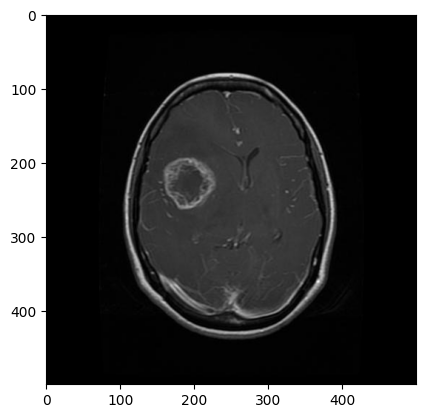

In [6]:
diagnose(glioma1)
diagnose(glioma1, trl)

BTS model has concluded that there is no tumor.
Using TRL model to make sure it is not a false negative, as this model performs better in these cases.
TRL model has confirmed the diagnosis:
No tumor detected


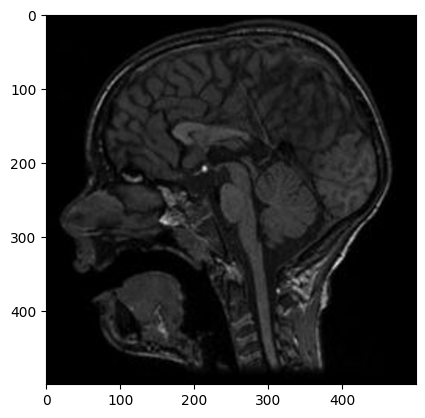

In [7]:
diagnose(notumor1)